In [0]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

DataPath = '/content/gdrive/My Drive/Data/RWTH/'
def load_data():
    
    filestruct=h5py.File(DataPath+'complete_with_noise.mat')

    data_normal=filestruct['data']['normal_images']
    data_speckle=filestruct['data']['speckle_images']

    data_normal=np.swapaxes(data_normal,0,1)
    data_speckle=np.swapaxes(data_speckle,0,1)
    
    x_train=data_normal[0:20000]
    x_test=data_normal[20000:-1]
    x_train_noisy=data_speckle[0:20000]
    x_test_noisy=data_speckle[20000:-1]
    
    return (x_train_noisy, x_train), (x_test_noisy, x_test)
    
def preprocess_data(data):

    data=np.log10(data + 0.01)
    max_val=np.max(data, axis=1)
    data=data/max_val.reshape(len(max_val), 1)
    data = np.reshape(data, (len(data), 64, 64, 1))
    data = np.clip(data, 0., 1.)
    
    return data

def plot_examples(x_noisy, x, fname='examples.png'):
    
    n = 10
    fig = plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i,:,:,0])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, n, n+i+1)
        plt.imshow(x[i,:,:,0])
        plt.xticks([])
        plt.yticks([])

    fig.savefig(fname)


In [0]:
TestData1 = np.load(DataPath + 'AuCd_302_0K_H_III_1.npy')
TestData2 = np.load(DataPath + 'cb019_103.npy')
TestData3 = np.load(DataPath + 'cb019_100.npy')

In [0]:
"""
Calculate the reconstructions of measured scattering patterns with your trained
models.
"""
import numpy as np
import matplotlib.pyplot as plt
# import dlipr
from tensorflow import keras
# import speckles


def preprocess_data(data, norm_data):
    # logarithmic intensity values
    data = np.log10(data + 0.01)
    norm_data = np.log10(norm_data + 0.01)
    # norm input data to max. value of undistorted scattering pattern
    max_val = np.max(norm_data, axis=1)
    data = data/max_val.reshape(len(max_val), 1)
    # reshape data for convolutional network
    data = np.reshape(data, (len(data), 64, 64, 1))
    # limit maximum intensity values
    data = np.clip(data, 0., 1.1)

    return data


# read in measured scattering patterns
real_names = [TestData3, TestData2, TestData1]
real_imgs = np.empty((len(real_names), 64*64))
for i in range(3):
    img = real_names[i]
    img = img[np.newaxis]
    real_imgs[i, :] = img

real_imgs = preprocess_data(real_imgs, real_imgs)
print(real_imgs.shape)


(3, 64, 64, 1)


#Preprocessing

(20000, 64, 64, 1)


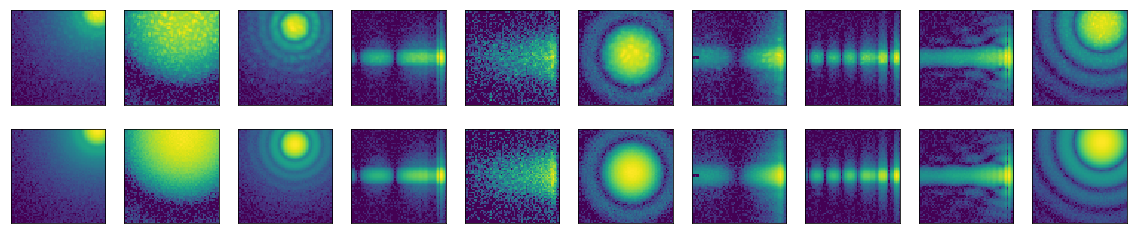

In [0]:
"""
Try to remove the speckles from the test images.
Set up models for a flat and a deep autoencoder.
Train the deep autoencoder with and without shortcut connections!
"""

import numpy as np
import matplotlib.pyplot as plt
# import dlipr
from tensorflow import keras
# import speckles


def preprocess_data(data, norm_data):
    # logarithmic intensity values
    data = np.log10(data + 0.01)
    norm_data = np.log10(norm_data + 0.01)
    # norm input data to max. value of undistorted scattering pattern
    max_val = np.max(norm_data, axis=1)
    data = data/max_val.reshape(len(max_val), 1)
    # reshape data for convolutional network
    data = np.reshape(data, (len(data), 64, 64, 1))
    # limit maximum intensity values
    data = np.clip(data, 0., 1.1)

    return data


(x_train_noisy, x_train), (x_test_noisy, x_test) = load_data()

x_train_noisy = preprocess_data(x_train_noisy, x_train)
x_train = preprocess_data(x_train, x_train)
x_test_noisy = preprocess_data(x_test_noisy, x_test)
x_test = preprocess_data(x_test, x_test)

plot_examples(x_test_noisy, x_test, fname='speckle_examples.png')
print(x_train_noisy.shape)

# some indices of interesting test data (it is not necessary to inspect all)
n = [1, 2, 4, 6, 10, 12, 14, 16, 22, 25, 27, 28, 30, 32, 35, 37, 39, 40, 41, 48, 49, 50, 52, 57, 61, 63, 64, 67, 70, 76]

In [0]:
print(x_train_noisy.shape)
print(x_train.shape)
print(x_test_noisy.shape)
print(x_test.shape)

(20000, 64, 64, 1)
(20000, 64, 64, 1)
(5499, 64, 64, 1)
(5499, 64, 64, 1)


# Task 1,2

In [0]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,add
from keras.models import Model
from keras.optimizers import RMSprop
import tensorflow as tf

In [0]:
batch_size = 128
epochs = 100
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))

In [0]:
def AutoencoderShallow(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 

    #decoder
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2) 
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

def AutoencoderDeep(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3) 

    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6)     
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

def AutoencoderDeepWithShortcuts(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    print('pool1',pool1.shape)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    print('pool2',pool2.shape)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    print('pool3',pool3.shape)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3) 

    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    ResUp1 = Conv2D(128, (1, 1), strides=(2, 2), activation='relu', padding='same')(up1)
    up1 = add([ResUp1,pool3])
    print('up1',up1.shape)

    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6)     
    ResUp2 = Conv2D(64, (1, 1), strides=(1, 1), activation='relu', padding='same')(up2)
    up2 = add([ResUp2,pool2])
    print('up2',up2.shape)

    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    ResUp3 = Conv2D(32, (1, 1), strides=(1, 1), activation='relu', padding='same')(up3)
    up3 = add([ResUp3,pool1])
    up3 = UpSampling2D((2,2))(up3) 

    print('up3',up3.shape)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

##Shallow Autoencoder

In [0]:
AutoencoderShallow = Model(input_img, AutoencoderShallow(input_img))
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
AutoencoderShallow.compile(loss='mean_squared_error', optimizer = Adam)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
AutoencoderShallow.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 1)         577       
Total para

In [0]:
AutoencoderShallow_train = AutoencoderShallow.fit(x_train_noisy, x_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test_noisy, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5499 samples
Epoch 1/100
20000/20000 [==============================] - 11s 558us/step - loss: 0.0146 - val_loss: 0.0057
Epoch 2/100
20000/20000 [==============================] - 6s 315us/step - loss: 0.0053 - val_loss: 0.0048
Epoch 3/100
20000/20000 [==============================] - 6s 324us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/100
20000/20000 [==============================] - 6s 324us/step - loss: 0.0042 - val_loss: 0.0040
Epoch 5/100
20000/20000 [==============================] - 7s 331us/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/100
20000/20000 [==============================] - 7s 331us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/100
20000/20000 [==============================] - 7s 331us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/100
20000/20000 [==============================] - 7s 330us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/100
20000/20000 [=====================

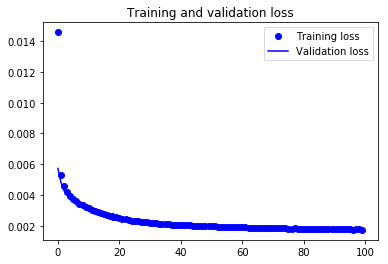

In [0]:
loss = AutoencoderShallow_train.history['loss']
val_loss = AutoencoderShallow_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
PredictionAutoencoderShallow = AutoencoderShallow.predict(x_test_noisy)
PredictionAutoencoderShallowRealImages = AutoencoderShallow.predict(real_imgs)

In [0]:
print(PredictionAutoencoderShallow.shape)
print(PredictionAutoencoderShallowRealImages.shape)

(5499, 64, 64, 1)
(3, 64, 64, 1)


Test Images


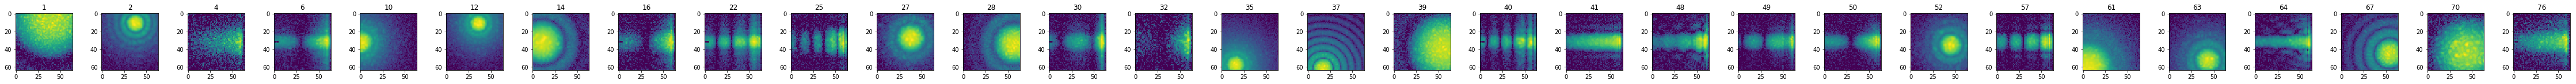

Reconstruction of Test Images for Deep Autoencoder with shortcuts


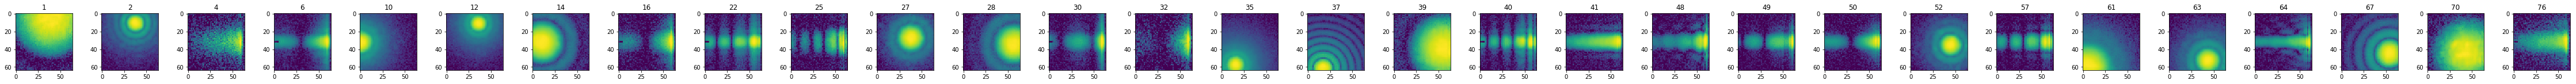

In [0]:
plt.figure(figsize=(80, 4))
print("Test Images")
n = [1, 2, 4, 6, 10, 12, 14, 16, 22, 25, 27, 28, 30, 32, 35, 37, 39, 40, 41, 48, 49, 50, 52, 57, 61, 63, 64, 67, 70, 76]
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    plt.imshow(x_test_noisy[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(80, 4))
print("Reconstruction of Test Images for Deep Autoencoder with shortcuts")
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    count +=1
    plt.imshow(PredictionAutoencoderShallow[i,:,:,0])  
    plt.title(str(i))

plt.show()

Real Images


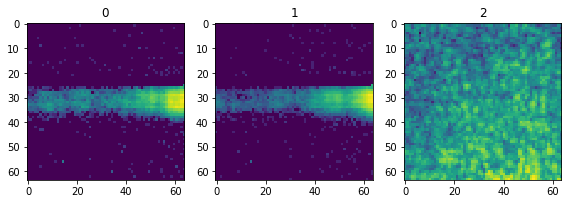

Reconstruction of Real Images for Deep Autoencoder with shortcuts


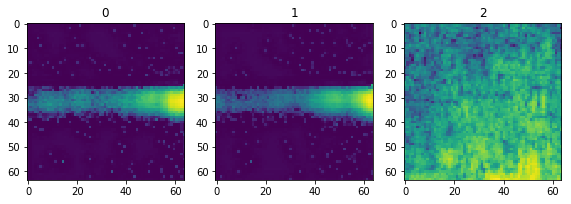

In [0]:
plt.figure(figsize=(40, 4))
print("Real Images")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    plt.imshow(real_imgs[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(40, 4))
print("Reconstruction of Real Images for Deep Autoencoder with shortcuts")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    count +=1
    plt.imshow(PredictionAutoencoderShallowRealImages[i,:,:,0])  
    plt.title(str(i))

plt.show()

## Deep Autoencoder without shortcuts

In [0]:
AutoencoderDeep = Model(input_img, AutoencoderDeep(input_img))
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
AutoencoderDeep.compile(loss='mean_squared_error', optimizer = Adam)

In [0]:
AutoencoderDeep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [0]:
AutoencoderDeep_train = AutoencoderDeep.fit(x_train_noisy, x_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test_noisy, x_test))

Train on 20000 samples, validate on 5499 samples
Epoch 1/100
20000/20000 [==============================] - 11s 566us/step - loss: 0.0170 - val_loss: 0.0084
Epoch 2/100
20000/20000 [==============================] - 10s 485us/step - loss: 0.0077 - val_loss: 0.0070
Epoch 3/100
20000/20000 [==============================] - 10s 478us/step - loss: 0.0069 - val_loss: 0.0066
Epoch 4/100
20000/20000 [==============================] - 9s 474us/step - loss: 0.0066 - val_loss: 0.0064
Epoch 5/100
20000/20000 [==============================] - 9s 473us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 6/100
20000/20000 [==============================] - 9s 474us/step - loss: 0.0063 - val_loss: 0.0061
Epoch 7/100
20000/20000 [==============================] - 9s 472us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/100
20000/20000 [==============================] - 9s 472us/step - loss: 0.0061 - val_loss: 0.0059
Epoch 9/100
20000/20000 [==============================] - 9s 473us/step - loss: 0.0060 - va

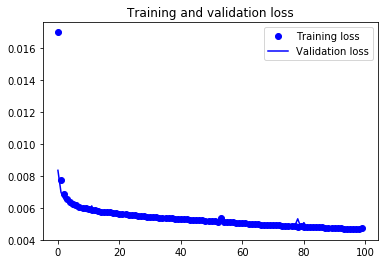

In [0]:
loss = AutoencoderDeep_train.history['loss']
val_loss = AutoencoderDeep_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
PredictionAutoencoderDeep = AutoencoderDeep.predict(x_test_noisy)
PredictionAutoencoderDeepRealImages = AutoencoderDeep.predict(real_imgs)

In [0]:
print(PredictionAutoencoderDeep.shape)
print(PredictionAutoencoderDeepRealImages.shape)

(5499, 64, 64, 1)
(3, 64, 64, 1)


Test Images


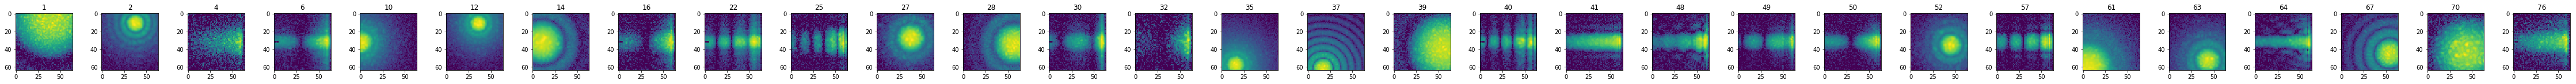

Reconstruction of Test Images for Deep Autoencoder without shortcuts


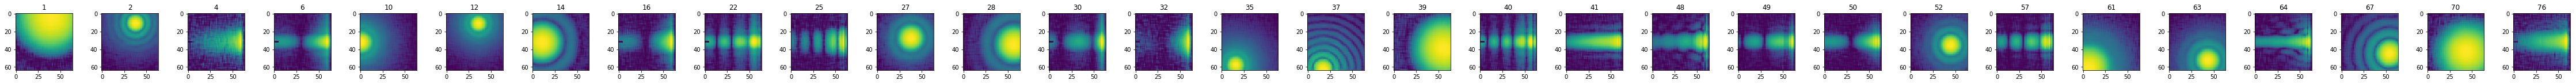

In [0]:
plt.figure(figsize=(80, 4))
print("Test Images")
n = [1, 2, 4, 6, 10, 12, 14, 16, 22, 25, 27, 28, 30, 32, 35, 37, 39, 40, 41, 48, 49, 50, 52, 57, 61, 63, 64, 67, 70, 76]
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    plt.imshow(x_test_noisy[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(80, 4))
print("Reconstruction of Test Images for Deep Autoencoder without shortcuts")
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    count +=1
    plt.imshow(PredictionAutoencoderDeep[i,:,:,0])  
    plt.title(str(i))

plt.show()

Real Images


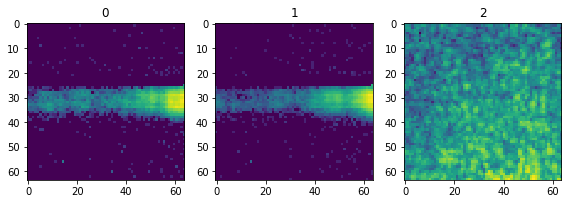

Reconstruction of Real Images for Deep Autoencoder without shortcuts


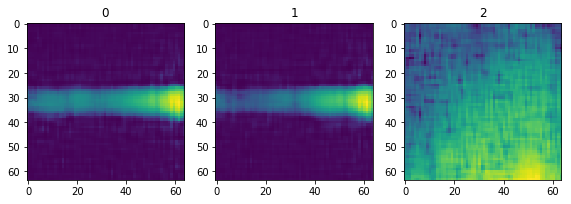

In [0]:
plt.figure(figsize=(40, 4))
print("Real Images")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    plt.imshow(real_imgs[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(40, 4))
print("Reconstruction of Real Images for Deep Autoencoder without shortcuts")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    count +=1
    plt.imshow(PredictionAutoencoderDeepRealImages[i,:,:,0])  
    plt.title(str(i))

plt.show()

## Deep Autoencoder with shortcuts

In [0]:
AutoencoderDeepWithShortcuts = Model(input_img, AutoencoderDeepWithShortcuts(input_img))
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
AutoencoderDeepWithShortcuts.compile(loss='mean_squared_error', optimizer = Adam)

pool1 (?, 32, 32, 32)
pool2 (?, 16, 16, 64)
pool3 (?, 8, 8, 128)
up1 (?, 8, 8, 128)
up2 (?, 16, 16, 64)
up3 (?, 64, 64, 32)


In [0]:
AutoencoderDeepWithShortcuts.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 64)   18496       max_pooling2d_8[0][0]            
__________________________________________________________________________________________________
max_poolin

In [0]:
AutoencoderDeepWithShortcuts_train = AutoencoderDeepWithShortcuts.fit(x_train_noisy, x_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test_noisy, x_test))

Train on 20000 samples, validate on 5499 samples
Epoch 1/100
20000/20000 [==============================] - 8s 420us/step - loss: 0.0141 - val_loss: 0.0067
Epoch 2/100
20000/20000 [==============================] - 7s 357us/step - loss: 0.0065 - val_loss: 0.0061
Epoch 3/100
20000/20000 [==============================] - 7s 358us/step - loss: 0.0060 - val_loss: 0.0057
Epoch 4/100
20000/20000 [==============================] - 7s 357us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/100
20000/20000 [==============================] - 7s 357us/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/100
20000/20000 [==============================] - 7s 356us/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/100
20000/20000 [==============================] - 7s 356us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/100
20000/20000 [==============================] - 7s 355us/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/100
20000/20000 [==============================] - 7s 355us/step - loss: 0.0047 - val_l

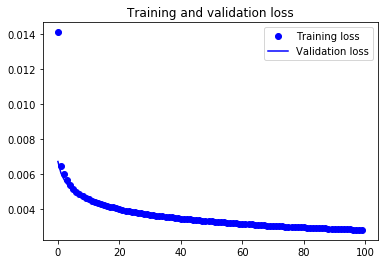

In [0]:
loss = AutoencoderDeepWithShortcuts_train.history['loss']
val_loss = AutoencoderDeepWithShortcuts_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
PredictionAutoencoderDeepWithShortcuts = AutoencoderDeepWithShortcuts.predict(x_test_noisy)
PredictionAutoencoderDeepWithShortcutsRealImages = AutoencoderDeepWithShortcuts.predict(real_imgs)

In [0]:
print(PredictionAutoencoderDeepWithShortcuts.shape)
print(PredictionAutoencoderDeepWithShortcutsRealImages.shape)

(5499, 64, 64, 1)
(3, 64, 64, 1)


Test Images


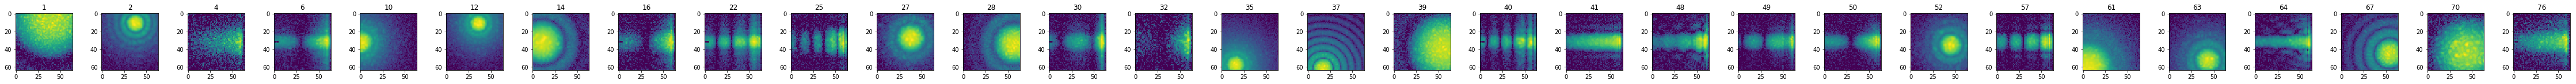

Reconstruction of Test Images for Deep Autoencoder with shortcuts


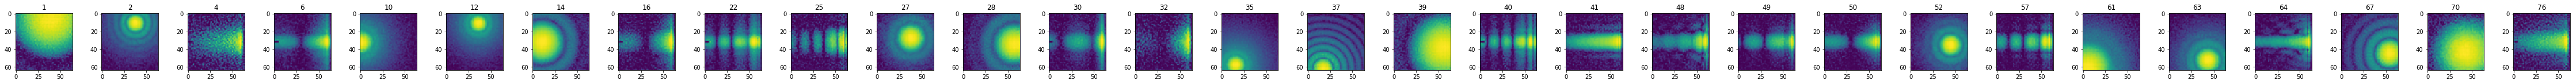

In [0]:
plt.figure(figsize=(80, 4))
print("Test Images")
n = [1, 2, 4, 6, 10, 12, 14, 16, 22, 25, 27, 28, 30, 32, 35, 37, 39, 40, 41, 48, 49, 50, 52, 57, 61, 63, 64, 67, 70, 76]
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    plt.imshow(x_test_noisy[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(80, 4))
print("Reconstruction of Test Images for Deep Autoencoder with shortcuts")
count = 0
for i in n:
    plt.subplot(2, len(n), count+1)
    count +=1
    plt.imshow(PredictionAutoencoderDeepWithShortcuts[i,:,:,0])  
    plt.title(str(i))

plt.show()

Real Images


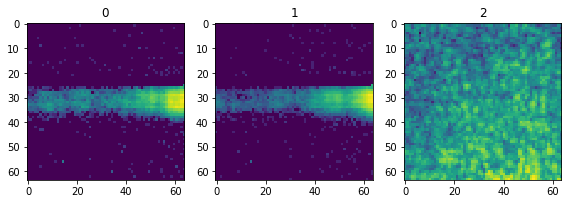

Reconstruction of Real Images for Deep Autoencoder with shortcuts


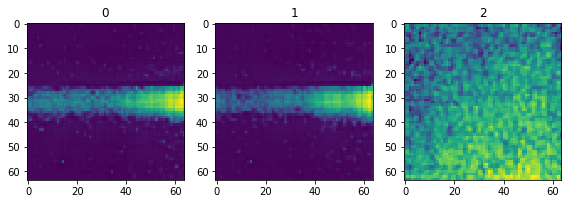

In [0]:
plt.figure(figsize=(40, 4))
print("Real Images")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    plt.imshow(real_imgs[i,:,:,0])
    count +=1
    plt.title(str(i))
plt.show()    
plt.figure(figsize=(40, 4))
print("Reconstruction of Real Images for Deep Autoencoder with shortcuts")
count = 0
for i in range(3):
    plt.subplot(1, 12, count+1)
    count +=1
    plt.imshow(PredictionAutoencoderDeepWithShortcutsRealImages[i,:,:,0])  
    plt.title(str(i))

plt.show()